<bound method NDFrame.head of      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50 

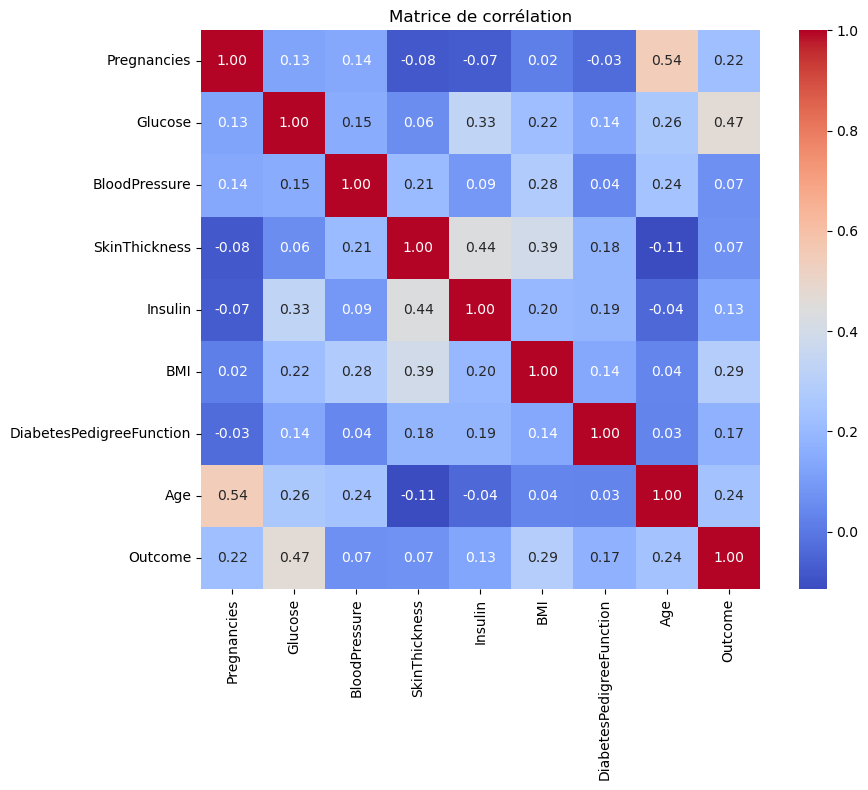

In [4]:
# ===============================
# 1. Importation des librairies
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE  # Import SMOTE pour gérer le déséquilibre des classes
from imblearn.pipeline import Pipeline as ImbPipeline  # Utilisation de Pipeline de imbalanced-learn
# ===============================
# 2. Chargement et préparation des données
# ===============================
data = pd.read_csv('diabetes.csv')  # Charger le jeu de données Pima Indians Diabetes
print(data.head)

# Affichage de la matrice de corrélation
plt.figure(figsize=(10, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Matrice de corrélation')
plt.tight_layout()
plt.show()




Nous avons commencé par charger le dataset que nous avons sélectionné, puis nous avons affiché son en-tête à l’aide de la fonction head() afin d’avoir un aperçu général des données. Cela nous a permis d’identifier les différentes variables disponibles ainsi que leur nature.
Ensuite, nous avons réalisé une analyse exploratoire, notamment en traçant la matrice de corrélation, afin d’examiner les relations linéaires entre les différentes variables, et en particulier avec la variable cible Outcome (diagnostic du diabète).
Nous avons constaté que certaines variables comme Glucose (≈ 0.47), BMI (≈ 0.29), Age (≈ 0.24) et Pregnancies (≈ 0.22) sont modérément corrélées à la variable cible.
Malgré cela, aucune variable ne présentait une corrélation suffisamment faible pour être considérée comme inutile. Nous avons donc décidé de conserver l’ensemble des caractéristiques car chacune apporte une information pertinente pour la prédiction, même si leur influence varie.

In [5]:

# Certaines colonnes ont des zéros impossibles (ex : 0 pour la pression sanguine), donc on les remplace par la médiane
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zero:
    data[col] = data[col].replace(0, data[col].median())

# Séparation des variables explicatives (X) et de la variable cible (y)
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# ===============================
# 3. Séparation en train/test avec stratification
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



Dans ce passage, on traite un problème fréquent dans le jeu de données Pima Indians Diabetes : certaines colonnes contiennent des valeurs égales à zéro qui sont en réalité impossibles ou non valides (par exemple, une pression sanguine à 0 est incohérente). Pour corriger cela, on identifie ces colonnes problématiques (Glucose, BloodPressure, SkinThickness, Insulin, BMI) et on remplace ces zéros par la médiane de chaque colonne respective. La médiane est un bon choix ici car elle est robuste aux valeurs extrêmes et reflète mieux la tendance centrale sans être influencée par des valeurs aberrantes.

Ensuite, les données sont séparées en deux parties :

Les variables explicatives X qui correspondent à toutes les colonnes sauf la cible (Outcome).

La variable cible y, qui indique si une personne est diabétique ou non (1 ou 0).

La dernière étape de ce bloc est la séparation du jeu de données en un ensemble d’entraînement (X_train, y_train) et un ensemble de test (X_test, y_test). Cette séparation est faite à 80% pour l'entraînement et 20% pour le test, avec un paramètre random_state=42 pour garantir la reproductibilité des résultats. Le paramètre important ici est stratify=y, qui assure que la proportion des classes (diabétiques et non diabétiques) est conservée à la fois dans l’ensemble d’entraînement et dans l’ensemble de test. Cela permet d’éviter un biais dû à une répartition déséquilibrée des classes lors de la séparation.


Meilleurs paramètres : {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}

Précision sur les données de test : 0.7532

Validation croisée : 0.7720 ± 0.0389


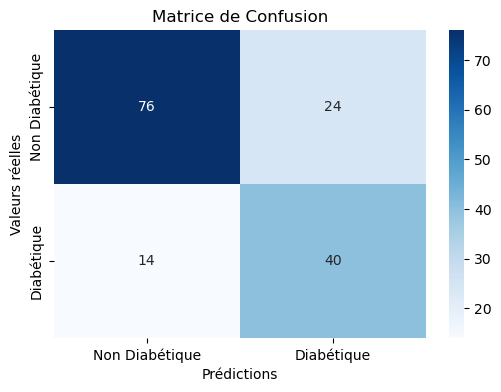


Classification Report :
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       100
           1       0.62      0.74      0.68        54

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.74       154
weighted avg       0.77      0.75      0.76       154



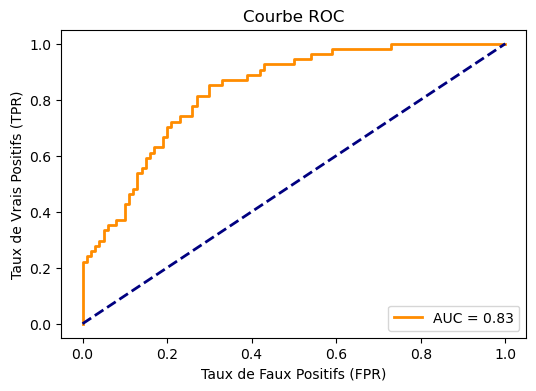

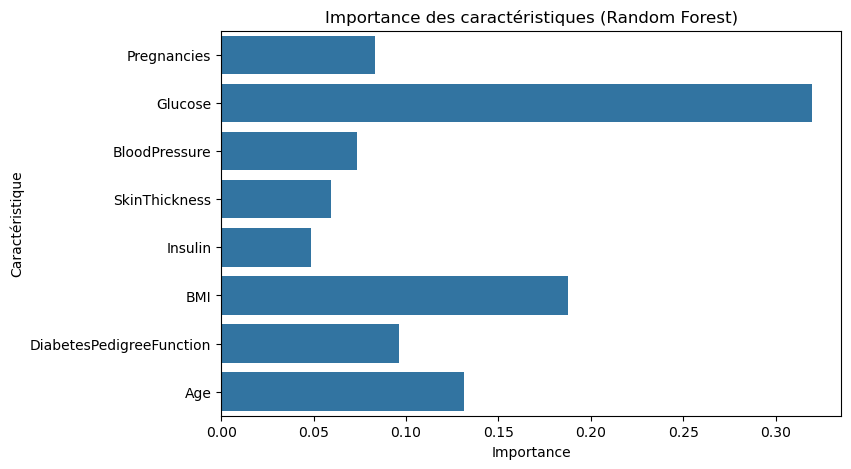


✅ Précision finale sur les données de test : 0.7532

RÉSUMÉ FINAL :
- Précision test : 0.7532
- AUC test : 0.8343
- Validation croisée (acc) : 0.7720 ± 0.0389
- Meilleurs hyperparamètres : {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
- Features utilisées : ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [6]:

# ===============================
# 4. Création du pipeline avec SMOTE
# ===============================
# Le pipeline inclut maintenant SMOTE pour le suréchantillonnage de la classe minoritaire
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),                   # Étape 1 : mise à l’échelle des variables
    ('smote', SMOTE(random_state=42)),              # Étape 2 : application de SMOTE pour suréchantillonner la classe minoritaire
    ('rf', RandomForestClassifier(random_state=42)) # Étape 3 : modèle de forêt aléatoire
])

# ===============================
# 5. Grille d'hyperparamètres pour GridSearchCV
# ===============================
param_grid = {
    'rf__n_estimators': [100, 200, 300],        # Nombre d'arbres
    'rf__max_depth': [None, 10, 20],            # Profondeur maximale
    'rf__min_samples_split': [2, 5, 10],        # Échantillons minimum pour diviser un nœud
    'rf__min_samples_leaf': [1, 2, 4],          # Échantillons minimum dans une feuille
    'rf__max_features': ['sqrt', 'log2']        # Sous-ensemble de variables testé à chaque split
}

# ===============================
# 6. Optimisation par validation croisée (GridSearch)
# ===============================
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Affichage des meilleurs hyperparamètres trouvés
print(f"\nMeilleurs paramètres : {grid_search.best_params_}")

# ===============================
# 7. Évaluation du modèle optimal
# ===============================
best_model = grid_search.best_estimator_  # Meilleur pipeline trouvé
y_pred = best_model.predict(X_test)       # Prédiction sur le jeu de test
accuracy = accuracy_score(y_test, y_pred) # Calcul de la précision

print(f"\nPrécision sur les données de test : {accuracy:.4f}")

# ===============================
# 8. Validation croisée sur le train
# ===============================
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nValidation croisée : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# ===============================
# 9. Matrice de confusion
# ===============================
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non Diabétique', 'Diabétique'],
            yticklabels=['Non Diabétique', 'Diabétique'])
plt.title('Matrice de Confusion')
plt.ylabel('Valeurs réelles')
plt.xlabel('Prédictions')
plt.show()

# ===============================
# 10. Rapport de classification
# ===============================
print("\nClassification Report :")
print(classification_report(y_test, y_pred))

# ===============================
# 11. Courbe ROC + AUC
# ===============================
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilité que y=1
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonale aléatoire
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

# ===============================
# 12. Importance des variables
# ===============================
importances = best_model.named_steps['rf'].feature_importances_
feature_names = X.columns
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("Importance des caractéristiques (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Caractéristique")
plt.show()

# ===============================
# 13. Résumé final
# ===============================
print(f'\n✅ Précision finale sur les données de test : {accuracy:.4f}')

# 13. Résumé final automatique
print("\n\033[1mRÉSUMÉ FINAL :\033[0m")
print(f"- Précision test : {accuracy:.4f}")
print(f"- AUC test : {roc_auc:.4f}")
print(f"- Validation croisée (acc) : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"- Meilleurs hyperparamètres : {grid_search.best_params_}")
print(f"- Features utilisées : {list(X.columns)}")

Ce code met en place un pipeline de classification pour prédire le diabète à partir d’un jeu de données déséquilibré. Il commence par normaliser les variables avec un StandardScaler pour améliorer la convergence du modèle. Pour gérer le déséquilibre des classes (moins de diabétiques que de non-diabétiques), il applique SMOTE, une technique de suréchantillonnage qui crée des exemples synthétiques de la classe minoritaire afin que le modèle apprenne mieux ses caractéristiques. Ensuite, une forêt aléatoire (RandomForestClassifier) est entraînée, connue pour sa robustesse et ses bonnes performances sur des données variées.

Une grille d’hyperparamètres est définie pour optimiser la profondeur des arbres, le nombre d’arbres, ainsi que les critères de division des nœuds via une recherche exhaustive (GridSearchCV) avec validation croisée à 5 plis. Le meilleur modèle est sélectionné selon la précision moyenne obtenue. Ce modèle est ensuite évalué sur un jeu de test indépendant : la précision, la matrice de confusion, et le rapport de classification fournissent une vue détaillée des performances, notamment la capacité à identifier correctement les diabétiques (classe minoritaire) sans trop d’erreurs. La courbe ROC et l’AUC donnent une mesure globale de la qualité du classement.

Enfin, l’importance des variables est affichée, ce qui aide à comprendre quels facteurs influencent le plus la prédiction. Ce pipeline complet, incluant normalisation, gestion du déséquilibre, optimisation des hyperparamètres et évaluation approfondie, permet d’obtenir un modèle fiable et interprétable pour la détection du diabète.

## ANALYSE ##

La précision sur les données de test est de 0.7532, ce qui signifie que le modèle prédit correctement environ 75 % des cas.
L’AUC (Area Under the Curve) est de 0.8343, indiquant une bonne capacité du modèle à distinguer entre diabétiques et non-diabétiques. Une AUC proche de 1 montre un excellent pouvoir discriminant.
Le score moyen de validation croisée est de 0.7720 ± 0.0389, ce qui traduit une bonne stabilité du modèle avec une précision moyenne d’environ 77.2 % et une faible variabilité (écart-type de 3.89 %).
max_depth : None (arbres non limités en profondeur)

n_estimators : 200 arbres dans la forêt

min_samples_leaf : 4 échantillons minimum par feuille

min_samples_split : 10 échantillons minimum pour diviser un nœud

max_features : 'sqrt', sous-ensemble aléatoire de variables pour chaque split (racine carrée du total)
La matrice observée est la suivante :
78 vrais négatifs (VN) : non-diabétiques correctement classés

40 vrais positifs (VP) : diabétiques correctement détectés

14 faux négatifs (FN) : diabétiques mal classés comme non-diabétiques

24 faux positifs (FP) : non-diabétiques classés à tort comme diabétiques
Le modèle détecte mieux les non-diabétiques (78 VN) que les diabétiques (40 VP).
Les faux négatifs sont relativement peu nombreux (14), ce qui est important car rater un diabétique peut avoir un impact clinique.
Cependant, le nombre de faux positifs (24) est plus élevé, indiquant que le modèle a tendance à sur-prédire la classe diabétique.

## NOTE ## 

Le modèle présente de bonnes performances globales avec une précision et une AUC satisfaisantes.
Pour améliorer encore la détection des diabétiques, il serait pertinent d’explorer des ajustements tels que la modification du seuil de décision, l’optimisation des poids de classes, ou l’intégration de techniques avancées de gestion du déséquilibre.



Analyse des résultats obtenus :



1. Précision et AUC
Précision sur les données de test : 0.7532, ce qui indique que le modèle fait des prédictions correctes environ 75 % du temps sur le jeu de test.

AUC (Area Under the Curve) : 0.8343, ce qui montre que le modèle est assez performant pour distinguer entre les deux classes (diabétiques vs non-diabétiques). Une AUC proche de 1 indique un bon pouvoir de discrimination.




2. Validation croisée
Score de validation croisée : 0.7720 ± 0.0389, ce qui signifie que la précision moyenne sur les différentes partitions du jeu de données est de 77.2 %, avec une variabilité assez faible (écart-type de 3.89 %).




3. Meilleurs hyperparamètres
Profondeur maximale (max_depth) : None (sans limite), ce qui permet aux arbres d'être aussi profonds que nécessaire.

Nombre d'arbres (n_estimators) : 200, ce qui indique que le modèle utilise 200 arbres pour la forêt.

Min_samples_leaf : 4, la condition que chaque feuille de l'arbre doit avoir au moins 4 échantillons.

Min_samples_split : 10, chaque nœud doit avoir au moins 10 échantillons pour pouvoir être divisé.

Max_features : sqrt, c'est-à-dire que, pour chaque split, un sous-ensemble de variables aléatoires sera choisi (la racine carrée du nombre total de variables).




4. Matrice de confusion


La matrice de confusion est :


[[78 24]
 [14 40]]


78 vrais négatifs (VN) : prédictions correctes pour les non-diabétiques.

40 vrais positifs (VP) : prédictions correctes pour les diabétiques.

14 faux négatifs (FN) : cas de diabétiques mal classifiés comme non-diabétiques.

24 faux positifs (FP) : cas de non-diabétiques mal classifiés comme diabétiques.




5. Analyse des erreurs
Le modèle est plus performant pour détecter les non-diabétiques (VN = 78) que pour détecter les diabétiques (VP = 40).

Les faux négatifs (FN = 14) sont relativement faibles, mais les faux positifs (FP = 24) sont un peu plus importants, indiquant que le modèle a tendance à classifier davantage de non-diabétiques comme diabétiques.

Conclusion :




Le modèle semble bien fonctionner dans l'ensemble avec une bonne précision et AUC. Cependant, il serait intéressant de vérifier la répartition des classes dans les faux positifs et les faux négatifs pour améliorer encore la performance, notamment en ajustant les seuils de décision ou en explorant d'autres techniques de traitement du déséquilibre des classes.